[View in Colaboratory](https://colab.research.google.com/github/seharanul17/Data_Science_competiton_2018/blob/master/model.ipynb)

In [245]:
#pytorch 0.4.0 설치
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

get_ipython().system('pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision')
import torch
print(torch.__version__)
print(torch.cuda.is_available())


#data uploading
# dataset 출처 kaggle 주소 :
# https://www.kaggle.com/uciml/restaurant-data-with-consumer-ratings#userprofile.csv

!wget 'https://www.dropbox.com/sh/hmr8q26s804lke1/AAA1bk3keYrntHx4qV8WhIGXa/rating_final.csv' # rating_final
!wget 'https://www.dropbox.com/sh/hmr8q26s804lke1/AABpUK-B6oJldokpNjjP6R8Va/userpayment.csv' #userpayment
!wget 'https://www.dropbox.com/sh/hmr8q26s804lke1/AAC2-c2LlKKyVQLJ11SBcZzSa/userprofile.csv' #userprofile

0.4.0
True
--2018-07-29 11:05:43--  https://www.dropbox.com/sh/hmr8q26s804lke1/AAA1bk3keYrntHx4qV8WhIGXa/rating_final.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/hmr8q26s804lke1/AAA1bk3keYrntHx4qV8WhIGXa/rating_final.csv [following]
--2018-07-29 11:05:43--  https://www.dropbox.com/sh/raw/hmr8q26s804lke1/AAA1bk3keYrntHx4qV8WhIGXa/rating_final.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc06fb0cfeb879ceb03c58c20dfb.dl.dropboxusercontent.com/cd/0/inline/AMna7NP6uthhbUhSo4sS3ru5VpMYLZmd6d8gYnCuIw1nTfmCmvo73sZ8HSTs61aHTtY6RrgMTLVBUNvRaFH804O-U8_GMITQVbS7uOxyUEzm7twb1mirX-cosXUnlkKsRHy0ZO8d3HjIJ7s0jXI9det1t1FiFc2cmbj04_2aGKVrD2Ximh4bDD3tEOYidGE1jSk/file [following]
--2018-07-29 11:05:43--  https://uc06fb0cfeb879

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data



# 데이터 읽기
rawData_userprofile = pd.read_csv('userprofile.csv', index_col='userID')
rawData_rating_final = pd.read_csv('rating_final.csv')
rawData_userpayment = pd.read_csv('userpayment.csv')

### 1. userpayment 데이터 전처리
# category를 integer로 라벨링(0~4)
le = preprocessing.LabelEncoder()
le.fit(rawData_userpayment[rawData_userpayment.columns[1]])
rawData_userpayment[rawData_userpayment.columns[1]]= le.transform(rawData_userpayment[rawData_userpayment.columns[1]])

# userpayment category를 one-hot vector로 라벨링 
rawData_userpayment = rawData_userpayment.join(pd.get_dummies(rawData_userpayment['Upayment']))
del rawData_userpayment['Upayment']

# userpayment 칼럼 이름 변경
rawData_userpayment.columns = ["userID", "pay_American_Express",'pay_MasterCard-Eurocard','pay_VISA','pay_bank_debit_cards','pay_cash']

# userpayment 라벨 갯수 sum
rawData_userpayment = rawData_userpayment.groupby('userID',as_index = False).sum()


### 2. rating 데이터 전처리
# rating_final 의미 없는 변수 제거
del rawData_rating_final['placeID']

# rating_final 라벨 mean
rawData_rating_final = rawData_rating_final.groupby('userID',as_index = False).mean()

# userID index 이용
rawData_rating_final.set_index('userID')
rawData_userpayment.set_index('userID')


### 3. userprofile 데이터 전처리
# drop missing data
rawData_userprofile = rawData_userprofile[rawData_userprofile[:] != '?']
rawData_userprofile = rawData_userprofile.dropna(how="any")

# 각각의 category를 integer로 라벨링
save_label = []
for i in range(rawData_userprofile.shape[1]):
    if type(rawData_userprofile[rawData_userprofile.columns[i]][0]) == str:
        le = preprocessing.LabelEncoder()
        le.fit(rawData_userprofile[rawData_userprofile.columns[i]])
        save_label.append(le.classes_)
        rawData_userprofile[rawData_userprofile.columns[i]] = le.transform(rawData_userprofile[rawData_userprofile.columns[i]])


### 4. 모든 feature들(rating, userpayper, userprofile)을 하나로 merge
common = pd.merge(rawData_rating_final,rawData_userpayment)
common = common.set_index('userID')
total_feature = common.join(rawData_userprofile)

# 최종적으로 missing data drop
total_feature = total_feature.dropna()


In [247]:
save_label # 인코더가 가진 정보들 순서

[array(['false', 'true'], dtype=object),
 array(['abstemious', 'casual drinker', 'social drinker'], dtype=object),
 array(['elegant', 'formal', 'informal', 'no preference'], dtype=object),
 array(['family', 'friends', 'solitary'], dtype=object),
 array(['car owner', 'on foot', 'public'], dtype=object),
 array(['married', 'single', 'widow'], dtype=object),
 array(['dependent', 'independent', 'kids'], dtype=object),
 array(['eco-friendly', 'none', 'retro', 'technology', 'variety'],
       dtype=object),
 array(['conformist', 'hard-worker', 'hunter-ostentatious',
        'thrifty-protector'], dtype=object),
 array(['Catholic', 'Christian', 'Jewish', 'Mormon', 'none'], dtype=object),
 array(['professional', 'student', 'unemployed', 'working-class'],
       dtype=object),
 array(['black', 'blue', 'green', 'orange', 'purple', 'red', 'white',
        'yellow'], dtype=object),
 array(['high', 'low', 'medium'], dtype=object)]

In [0]:
# correlation
#total_feature.corr()
#plt.matshow(total_feature.corr())

def draw_cor_matrix(features, num):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111)

  cax = ax.matshow(features.corr(),cmap=plt.cm.RdBu, vmin=-1, vmax=1)
  plt.title('Correlation matrix')
  fig.colorbar(cax)

  label = list(total_feature.columns)
  ax.set_xticklabels([''])
  ax.set_yticklabels([''] + label)

  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.xlabel('features')
  plt.ylabel('features')
  s = 'correlation_matrix'+str(num)+'.png'
  print(s + '  is saved')
  plt.savefig(s)

correlation_matrix1.png  is saved


,rating,food_rating,service_rating,pay_American_Express,pay_MasterCard-Eurocard,pay_VISA,pay_bank_debit_cards,pay_cash,latitude,longitude,...,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
rating,1.000000,0.879106,0.830590,0.139436,-0.032870,0.051460,0.194292,-0.131330,-0.218974,0.035756,...,-0.126524,-0.163176,-0.239543,-0.055133,-0.093541,-0.134124,-0.194060,-0.045228,0.004692,0.053949
food_rating,0.879106,1.000000,0.816611,0.149602,-0.004043,0.090134,0.275375,-0.169972,-0.132634,0.066005,...,-0.070289,-0.207671,-0.224086,0.056646,-0.027271,-0.170482,-0.243831,-0.030595,0.014673,0.015228
service_rating,0.830590,0.816611,1.000000,0.098051,-0.099712,0.090351,0.266588,-0.060731,-0.197288,0.010494,...,-0.042769,-0.232961,-0.170682,0.011961,-0.032315,-0.134599,-0.202211,0.014486,-0.017120,0.065115
pay_American_Express,0.139436,0.149602,0.098051,1.000000,-0.025031,0.331133,0.114867,-0.491228,-0.242601,0.171013,...,-0.029077,0.024779,-0.061215,0.074756,-0.069237,-0.136400,0.061600,-0.043955,0.084108,-0.041354
pay_MasterCard-Eurocard,-0.032870,-0.004043,-0.099712,-0.025031,1.000000,0.198431,0.038816,0.025031,-0.131930,0.049485,...,0.108903,-0.075578,0.075023,0.197637,0.025770,-0.314695,-0.106511,0.108228,0.120004,0.052860
pay_VISA,0.051460,0.090134,0.090351,0.331133,0.198431,1.000000,0.280708,-0.139076,-0.152900,-0.049942,...,0.230505,0.021468,0.124428,0.129480,-0.077273,-0.157757,0.071731,0.058547,0.161925,0.177653
pay_bank_debit_cards,0.194292,0.275375,0.266588,0.114867,0.038816,0.280708,1.000000,-0.114867,-0.406537,0.310927,...,0.263027,-0.237749,-0.022717,0.015911,-0.058092,-0.354028,0.014032,-0.104091,0.205784,-0.094475
pay_cash,-0.131330,-0.169972,-0.060731,-0.491228,0.025031,-0.139076,-0.114867,1.000000,0.243005,-0.172298,...,0.029077,0.173131,-0.075341,-0.138519,0.025588,-0.031924,-0.091878,0.043955,0.159805,0.169121
latitude,-0.218974,-0.132634,-0.197288,-0.242601,-0.131930,-0.152900,-0.406537,0.243005,1.000000,-0.352728,...,-0.081554,0.206079,0.108211,-0.130600,-0.040827,0.226880,0.107599,0.129074,-0.157705,0.102780
longitude,0.035756,0.066005,0.010494,0.171013,0.049485,-0.049942,0.310927,-0.172298,-0.352728,1.000000,...,-0.115042,-0.070146,0.018703,0.037125,0.068891,-0.176016,-0.047820,0.133448,0.211375,-0.017793


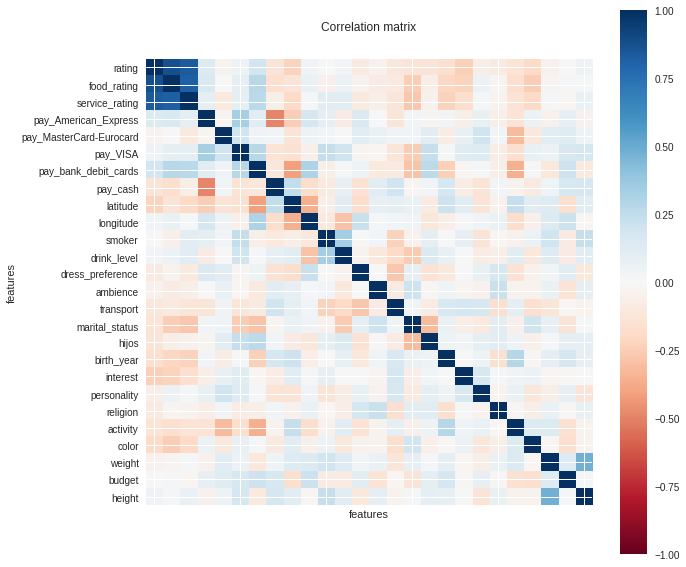

In [249]:
draw_cor_matrix(total_feature, 1)
total_feature.corr()

In [250]:
# 0 : conformist : 순응하는 사람
# 1 : hard-worker : 열심히 일하는 사람
# 2 : hunter-ostentatious : 겉멋든 사람을 사냥하는 사람 (?)
# 3 : thrifty-protector : 검소한사람

a=total_feature.groupby(['personality']).mean()

a=a.reset_index()
a['personality']= ['conformist','hard-worker','hunter-ostentatious','thrifty-protector']

a.set_index(['personality'])

a = total_feature.groupby(['personality']).mean()

a[a.columns[:7]]

a[a.columns[7:14]]

a[a.columns[14:21]]

a[a.columns[21:]]


,color,weight,budget,height
personality,,,,
0.0,3.428571,70.285714,1.142857,1.754286
1.0,2.382979,66.723404,1.723404,1.681064
2.0,4.181818,58.272727,1.545455,1.695455
3.0,2.078431,65.490196,1.686275,1.666863


correlation_matrix1.png  is saved


(116, 11)

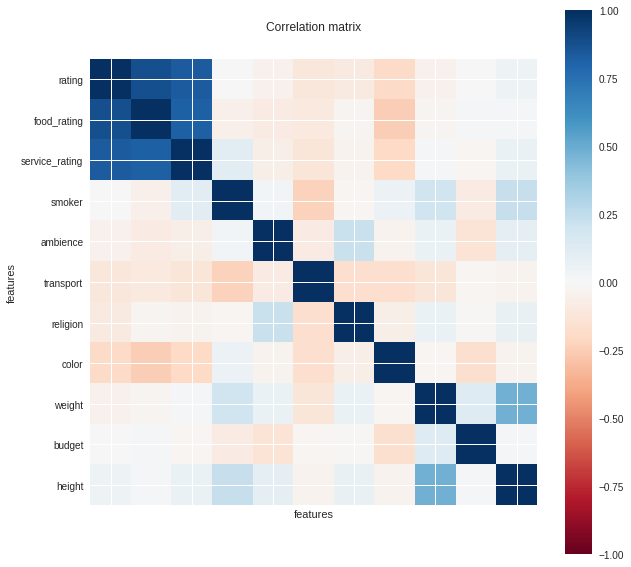

In [251]:
#네모박스 친 것들만 남기고, target을 제거
del total_feature['pay_American_Express']
del total_feature['pay_MasterCard-Eurocard']
del total_feature['pay_cash']
del total_feature['pay_VISA']
del total_feature['pay_bank_debit_cards']
del total_feature['longitude']
del total_feature['latitude']
del total_feature['drink_level']
del total_feature['dress_preference']
del total_feature['marital_status']
del total_feature['hijos']
del total_feature['birth_year']
del total_feature['interest']
del total_feature['activity']

# 제거하기전에 yData = target으로 저장해줌
yData = total_feature[['personality']]
del total_feature['personality']

draw_cor_matrix(total_feature, 1)
total_feature.shape



correlation_matrix2.png  is saved


(116, 8)

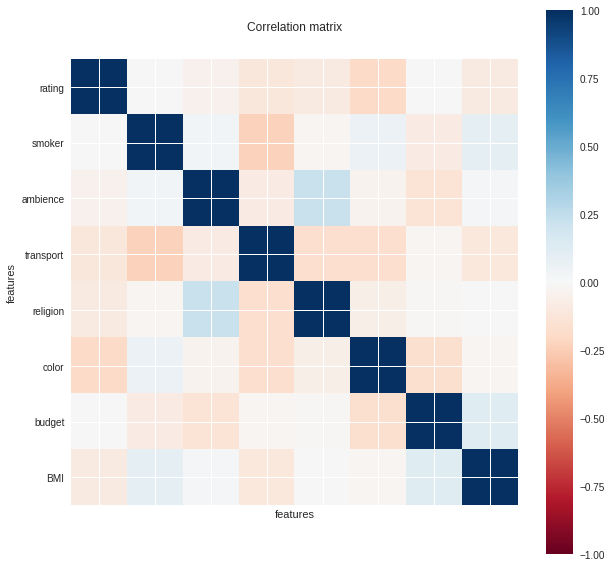

In [252]:
## dependent 한 feature들 제거 및 통합

del total_feature['food_rating']
del total_feature['service_rating']

# weight와 height로 새로운 feature BMI를 만들어서 사용
# BMI = weight / height**2
BMI = total_feature['weight']/total_feature['height']/total_feature['height']

BMI = pd.DataFrame(BMI)
BMI.columns = ["BMI"]

# BMI만 남기고 weight와 height는 제거
total_feature = total_feature.join(BMI)
del total_feature['weight']
del total_feature['height']

draw_cor_matrix(total_feature, 2)
total_feature.shape

In [253]:
total_feature.head()

,rating,smoker,ambience,transport,religion,color,budget,BMI
userID,,,,,,,,
U1001,1.111111,0.0,0.0,1.0,4.0,0.0,2.0,22.024323
U1002,1.400000,0.0,0.0,2.0,0.0,5.0,1.0,11.438703
U1003,1.615385,0.0,0.0,2.0,0.0,1.0,1.0,21.007668
U1004,1.875000,0.0,0.0,2.0,4.0,2.0,2.0,18.796189
U1005,1.333333,0.0,0.0,2.0,0.0,0.0,2.0,22.758307


In [255]:
### 6. target y('personality')와 feature X(나머지) 분리

#yData = total_feature['personality']
xData = total_feature

xData.head()

,rating,smoker,ambience,transport,religion,color,budget,BMI
userID,,,,,,,,
U1001,1.111111,0.0,0.0,1.0,4.0,0.0,2.0,22.024323
U1002,1.400000,0.0,0.0,2.0,0.0,5.0,1.0,11.438703
U1003,1.615385,0.0,0.0,2.0,0.0,1.0,1.0,21.007668
U1004,1.875000,0.0,0.0,2.0,4.0,2.0,2.0,18.796189
U1005,1.333333,0.0,0.0,2.0,0.0,0.0,2.0,22.758307


In [256]:
# feature scaling
xData = preprocessing.scale(xData.astype('float'))
xData = pd.DataFrame(xData)
#xData.columns = ['rating','drink_level',	'dress_preference',	'transport'	,'interest'	,'color',	'budget',	'BMI']

xData.head()


,0,1,2,3,4,5,6,7
0,-0.158631,-0.497305,-0.823525,-0.368741,2.113636,-1.135091,0.635001,-0.223634
1,0.371814,-0.497305,-0.823525,0.756889,-0.522727,1.150856,-1.206501,-2.303252
2,0.767294,-0.497305,-0.823525,0.756889,-0.522727,-0.677901,-1.206501,-0.423363
3,1.243989,-0.497305,-0.823525,0.756889,2.113636,-0.220712,0.635001,-0.857823
4,0.249404,-0.497305,-0.823525,0.756889,-0.522727,-1.135091,0.635001,-0.079438


In [0]:
### 7. train set와 test set 분리

# test set : 전체 data set의 20%
x_train, x_test, y_train, y_test = train_test_split(xData, yData, test_size=0.2)


In [0]:
# cross validation for Pytorch, validation set : x_train 데이터의 20%
CV = KFold(n_splits=5, shuffle=True, random_state=0) #5개로 나눕니다/// shuffle합니다/// random_state 는 단순히 random number 생성을 위한 숫자입니당.

i=0

for train_index, val_index in CV.split(x_train):   
    globals()['x_train_{}'.format(i)] = x_train.iloc[train_index] #변수명 동적할당 : x_train_0 ~ x_train_4 (5-fold cross validation)
    globals()['y_train_{}'.format(i)] = y_train.iloc[train_index]
    globals()['x_val_{}'.format(i)] = x_train.iloc[val_index]
    globals()['y_val_{}'.format(i)] = y_train.iloc[val_index]
    i+=1
    

x_trainset = [x_train_0, x_train_1, x_train_2, x_train_3, x_train_4]
y_trainset = [y_train_0, y_train_1, y_train_2, y_train_3, y_train_4]
x_valset = [x_val_0,x_val_1,x_val_2,x_val_3,x_val_4]
y_valset = [y_val_0,y_val_1,y_val_2,y_val_3,y_val_4]


In [0]:

#### 8. PyTorch로 모델 'pModel' 학습     
class pModel(nn.Module): 
    def __init__(self):
        super(pModel, self).__init__()
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 4)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        return out


In [260]:
 #dataset 처리  ######### cross validation을 위해 모델 설정과 위치를 바꾸었습니당!!!!


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hypter parameter
num_epoch = 1500
learning_rate = 0.003
batch_size = 20
weight_decay=0.03


n=100 # 100epoch 마다 출력합니다.
saveacc=0 # validation dataset accuracy mean 값 계산용
best_acc=0
best_model=0

for kf in range(5): # 5-fold 데이터 로드
    x_train_t = torch.tensor(x_trainset[kf].values).type(torch.FloatTensor).to(device) ########변수 구분을위해 torch.Tensor 는 _t 를 붙여주었습니다!!!!
    y_train_t = torch.tensor(y_trainset[kf].values).type(torch.LongTensor).to(device).view(-1)

    x_val_t = torch.tensor(x_valset[kf].values).type(torch.FloatTensor).to(device)
    y_val_t = torch.tensor(y_valset[kf].values).type(torch.LongTensor).to(device).view(-1)

    x_test_t = torch.tensor(x_test.values).type(torch.FloatTensor).to(device)
    y_test_t = torch.tensor(y_test.values).type(torch.LongTensor).to(device).view(-1)

    train_dataset = torch.utils.data.TensorDataset(x_train_t, y_train_t)
    val_dataset = torch.utils.data.TensorDataset(x_val_t, y_val_t)
    test_dataset = torch.utils.data.TensorDataset(x_test_t, y_test_t)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    
    ### 9. 학습 ( 5번 )
    
    model = pModel().to(device) # model weight init for cross validation #모델은 여기서 수정해주세용
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    show_loss = 0
    for epoch in range(num_epoch):
        for i, (inputs, labels) in enumerate(train_loader):

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            show_loss += float(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%len(train_loader)== 0 and (epoch+1)%n == 0:
              show_loss = show_loss/(len(train_loader)*100)
              print('K-fold [{}/{}], Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(kf+1, 5, epoch+1, num_epoch, i+1, len(train_loader), show_loss))
              show_loss = 0
    

    print('{}번째 CV 종료'.format(kf+1))
    
    
    ### validation set accuracy (mean of 5-fold accuracy)
    with torch.no_grad():
        correct = 0
        total = 0
        for (inputs, labels) in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        saveacc+=100 * correct / total
        print('{}번째 validation set Accuracy: {} %'.format(kf+1, 100*correct/total))
        if best_acc<100*correct/total:
            best_model=model
            best_acc = 100*correct/total
        if kf==4 : 
            print('Best validation set Accuracy: {} %'.format(best_acc) )


print('Learning finished')

### 10. test set accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (inputs, labels) in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_acc = 100*correct/total
    
### train set accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for (inputs, labels) in train_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = 100*correct/total
    print('epoch={}, lr={}, batch={}, weight={} : test {:.3} val {:.3} train {:.3}'.format(num_epoch, learning_rate, batch_size, weight_decay, test_acc, best_acc, train_acc))

K-fold [1/5], Epoch [100/1500], Step [4/4], Loss: 1.0732
K-fold [1/5], Epoch [200/1500], Step [4/4], Loss: 0.9629
K-fold [1/5], Epoch [300/1500], Step [4/4], Loss: 0.9533
K-fold [1/5], Epoch [400/1500], Step [4/4], Loss: 0.9495
K-fold [1/5], Epoch [500/1500], Step [4/4], Loss: 0.9402
K-fold [1/5], Epoch [600/1500], Step [4/4], Loss: 0.9313
K-fold [1/5], Epoch [700/1500], Step [4/4], Loss: 0.9237
K-fold [1/5], Epoch [800/1500], Step [4/4], Loss: 0.9152
K-fold [1/5], Epoch [900/1500], Step [4/4], Loss: 0.9087
K-fold [1/5], Epoch [1000/1500], Step [4/4], Loss: 0.8999
K-fold [1/5], Epoch [1100/1500], Step [4/4], Loss: 0.8952
K-fold [1/5], Epoch [1200/1500], Step [4/4], Loss: 0.8934
K-fold [1/5], Epoch [1300/1500], Step [4/4], Loss: 0.8907
K-fold [1/5], Epoch [1400/1500], Step [4/4], Loss: 0.8862
K-fold [1/5], Epoch [1500/1500], Step [4/4], Loss: 0.8808
1번째 CV 종료
1번째 validation set Accuracy: 47.36842105263158 %
K-fold [2/5], Epoch [100/1500], Step [4/4], Loss: 1.0302
K-fold [2/5], Epoch [20

K-fold [4/5], Epoch [1300/1500], Step [4/4], Loss: 0.9040
K-fold [4/5], Epoch [1400/1500], Step [4/4], Loss: 0.9040
K-fold [4/5], Epoch [1500/1500], Step [4/4], Loss: 0.9032
4번째 CV 종료
4번째 validation set Accuracy: 38.888888888888886 %
K-fold [5/5], Epoch [100/1500], Step [4/4], Loss: 1.0392
K-fold [5/5], Epoch [200/1500], Step [4/4], Loss: 0.9544
K-fold [5/5], Epoch [300/1500], Step [4/4], Loss: 0.9408
K-fold [5/5], Epoch [400/1500], Step [4/4], Loss: 0.9202
K-fold [5/5], Epoch [500/1500], Step [4/4], Loss: 0.8976
K-fold [5/5], Epoch [600/1500], Step [4/4], Loss: 0.8630
K-fold [5/5], Epoch [700/1500], Step [4/4], Loss: 0.8404
K-fold [5/5], Epoch [800/1500], Step [4/4], Loss: 0.8264
K-fold [5/5], Epoch [900/1500], Step [4/4], Loss: 0.8214
K-fold [5/5], Epoch [1000/1500], Step [4/4], Loss: 0.8194
K-fold [5/5], Epoch [1100/1500], Step [4/4], Loss: 0.8157
K-fold [5/5], Epoch [1200/1500], Step [4/4], Loss: 0.8098
K-fold [5/5], Epoch [1300/1500], Step [4/4], Loss: 0.8077
K-fold [5/5], Epoch [